In [115]:
from brainpipe.system import study
import numpy as np
from itertools import product
from os.path import join, exists
from os import makedirs
from scipy import stats
from mne.stats import fdr_correction, bonferroni_correction
from joblib import Parallel, delayed
import pandas as pd
import pingouin as pg

In [114]:
"""
Compute differences of tps wth depending on CATEGORY (odor,place,context)
1- ANOVA F-test TPSim self + T-tests btw category
"""
from scipy.special import comb
from collections import Counter
from pingouin import pairwise_gameshowell, welch_anova, pairwise_ttests
from os import listdir

###############################################################################
st = study('Olfacto')
path_od = join(st.path,'feature/TPSim_{}_By_Odor_By_Cond/TPS_by_odor/') #TPS_R_p_by_odor/
path_pos = join(st.path,'feature/TPSim_{}_By_Odor_By_Cond/TPS_by_pos/') #TPS_R_p_by_odor/
path_cont = join(st.path,'feature/TPSim_{}_By_Odor_By_Cond/TPS_by_context/') #TPS_R_p_by_odor/
###############################################################################

exp = 'Enc' #Ret, Enc, Enc_Ret
freqs = ['2_beta'] #0_theta 1_alpha, 2_beta 3_gamma
conds = ['high','low']
x0,y0,z0 = 20, 30,-16
x1,y1,z1 = -20, 32,-16
rad = 10
roi = 'aHC'
odors_su = { 'CHAF': {5:12,7:68,8:36,9:96,1:6,2:2,3:68,4:8},
            'LEFC': {1:4,2:0,3:6,4:12,14:96,15:2,16:4,17:68},
            'PIRJ': {4:36,9:2,1:4,18:32,6:34,5:4,7:68}, #missing odor 15
            'VACJ': {14:6,15:64,16:68,17:8,10:6,11:4,12:4,13:40},
            'SEMC': {10:2,11:6,12:6,13:6,5:8,7:4,8:8,9:10},
            'FERJ': {16:6,17:6,5:8,7:6,12:8,13:8,2:6,1:10}}

files_od = listdir(path_od.format(exp))
files_pos = listdir(path_pos.format(exp))
files_cont = listdir(path_cont.format(exp))

def concat_tps(f,type_tps):
    if type_tps == 'odor':
        path = path_od.format(exp)
    if type_tps == 'pos':
        path = path_pos.format(exp)
    if type_tps == 'cont':
        path = path_cont.format(exp)
    tps_od = np.load(path+f,allow_pickle=True)['tps']
    nelecs, ntrials = tps_od.shape
    all_tps_types.append(tps_od)
    wth = [type_tps]*ntrials
    wth_type.append(wth)

Tvals, pvals = [], []
Fvals, Fp = [], []
for su, freq in product(odors_su,freqs):
    all_tps_types, wth_type = [], []
    for od in odors_su[su]:
        if od in [1,4,5] and su == 'CHAF' and exp == 'Enc':
            continue
        if od in [6,5,7] and su == 'PIRJ' and exp=='Enc':
            continue
        else:
            for f in files_od: #create tps for odors
                if f.startswith('TPS_spear_{}_odor_{}_{}'.format(su,od,freq[2:])):
                    concat_tps(f,'odor')
            
            for f in files_pos: #create tps for pos
                if f.startswith('TPS_spear_{}_{}_{}_wth'.format(su,od,freq[2:])):
                    concat_tps(f,'pos')
    
            for f in files_cont: #create tps for cont
                if f.startswith('TPS_spear_{}_{}_{}_wth'.format(su,od,freq[2:])):
                    concat_tps(f,'cont')
                    mat = np.load(path_cont.format(exp)+f,allow_pickle=True)
                    
    channels, labels, xyz = mat['channel'], mat['label'], mat['xyz']
    wth_type = np.concatenate(wth_type,axis=0)
    all_tps_types = np.concatenate(all_tps_types,axis=1)
    
    Tvals_su, pvals_su = np.array([]), np.array([])
    for elec in range(channels.shape[0]):
        lab = labels[elec]
        x,y,z = xyz[elec][0], xyz[elec][1], xyz[elec][2]
        id_R = 1 if all([x0-rad<=x<=x0+rad, y0-rad<=y<=y0+rad,
                z0-rad<=z<=z0+rad]) else 0
        id_L = 1 if all([x1-rad<=x<=x1+rad, y1-rad<=y<=y1+rad,
                z1-rad<=z<=z1+rad]) else 0
        idx = id_R + id_L
        lab = 'OFC_olf' if idx == 1 else lab
        lab = 'aHC' if lab == 'HC' and y > -26 else lab
        
        if lab == roi:
            elec_wth = all_tps_types[elec]
            id_trials = [i+1 for i in range(len(elec_wth))]
            df = pd.DataFrame({'factor':wth_type,'tpsim':elec_wth,'id_trials':id_trials})
        
            #ANOVA for the main effect of TPSim type
            aov = welch_anova(data=df, dv='tpsim', between='factor')
            if aov['p-unc'].values < 0.003:
                Fvals.append(aov['F'].values[0])
                Fp.append(aov['p-unc'].values[0])

#                 print(elec,freq,su,lab,'Diff TPS MODALITY',aov)
                posthoc = pairwise_gameshowell(data=df, dv='tpsim', between='factor')
                sig = [1 for p in posthoc['pval'].values if p < 0.05]
                if sum(sig)>0:
#                     print(posthoc)
                    Tvals_su = np.vstack((Tvals_su,posthoc['T'].values)) if np.size(Tvals_su) else posthoc['T'].values
                    pvals_su = np.vstack((pvals_su,posthoc['pval'].values)) if np.size(pvals_su) else posthoc['pval'].values
    if np.size(Tvals_su):
        Tvals.append(Tvals_su), pvals.append(pvals_su)
        print(su)
print(freq,roi,len(Tvals))
print('anova',min(Fvals), max(Fp))

print(Tvals)
print(pvals)
#CO_sum, CP_sum, OP_sum = [], [], []
#CO_mean, CP_mean, OP_mean = [], [], []
#CO_T, CP_T, OP_T = [], [], []
#for i,sig in enumerate(pvals):
#    CO, CP, OP = 0, 0, 0
#    T_CO, T_CP, T_OP = [], [], []
#    M_CO, M_CP, M_OP = [], [], []
#    for elec in range(sig.shape[0]):
#        CO += 1 if sig[elec][0] < 0.05 else 0
#        T_CO.append(Tvals[i][elec][0])
#        CP += 1 if sig[elec][1] < 0.05 else 0
#        T_CP.append(Tvals[i][elec][1])
#        OP += 1 if sig[elec][2] < 0.05 else 0
#        T_OP.append(Tvals[i][elec][2])
#    CO_sum.append(CO), CP_sum.append(CP), OP_sum.append(OP)
#    CO_T.append(T_CO), CP_T.append(T_CP), OP_T.append(T_OP)
#    CO_T.append(T_CO), CP_T.append(T_CP), OP_T.append(T_OP)
#print(CO_sum,CP_sum,OP_sum)


-> Olfacto loaded
LEFC
PIRJ
VACJ
SEMC
FERJ
2_beta aHC 5
anova 6.48 0.002060537903707354
[array([[-2.693, -3.492,  0.483],
       [-3.859, -3.537,  1.441]]), array([[-1.638, -4.634, -1.68 ],
       [-4.262, -6.682, -0.598],
       [-4.587, -6.914, -0.601],
       [-3.282, -6.3  , -0.939]]), array([[-1.815, -3.881, -0.143],
       [-2.136, -4.083, -0.026],
       [-0.83 , -3.744, -0.95 ]]), array([[-1.807, -4.053, -0.715],
       [-4.42 , -9.806, -1.364],
       [-4.076, -4.718,  1.056],
       [-1.603, -3.701, -0.633]]), array([[-1.901, -5.038, -1.015],
       [-2.838, -4.145,  0.208],
       [-3.903, -2.548,  2.006],
       [-3.278, -2.175,  1.728],
       [-3.378, -2.507,  1.493],
       [-3.767, -1.024,  2.705]])]
[array([[0.01954951, 0.00139891, 0.88012668],
       [0.001     , 0.00118023, 0.32037288]]), array([[0.231321  , 0.001     , 0.21382576],
       [0.001     , 0.001     , 0.80170231],
       [0.001     , 0.001     , 0.79984474],
       [0.00319028, 0.001     , 0.6063675 ]]),

-> Olfacto loaded
FERJ


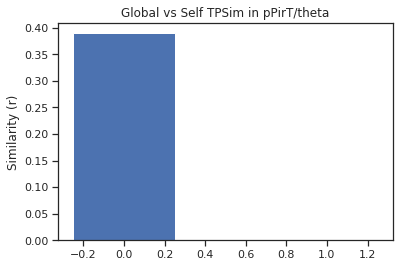

In [138]:
"""
Compute differences of tps wth and btw for all elecs
1- ANOVA F-test TPSim "self" > TPSim "btw"
2- ANOVA F-test TPSim self + T-tests btw odors
"""
###############################################################################
st = study('Olfacto')
path_npz = join(st.path,'feature/TPSim_{}_By_Odor_By_Cond/TPS_by_odor/') #TPS_R_p_by_odor/
path_btw = join(st.path,'feature/TPSim_{}_By_Odor_By_Cond/TPS_by_odor/') #TPS_R_p_by_odor/
tps_od_name = join(path_npz, 'TPS_spear_{}_odor_{}_{}.npz')
#tps_od_name = join(path_npz, 'TPS_spear_{}_{}_{}_wth_{}.npz')
#tps_btw_name = join(path_btw, 'TPS_spear_{}_{}_{}_btw_{}.npz')
tps_btw_name = join(path_btw, 'TPS_spear_{}_odor{}_btw_{}.npz')
###############################################################################
from scipy.special import comb
from collections import Counter
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
###############################################################################

exp = 'Ret' #Ret, Enc, Enc_Ret
freqs = ['0_theta'] #0_theta 1_alpha, 2_beta 3_gamma
conds = ['high','low']
x0,y0,z0 = 20, 30,-16
x1,y1,z1 = -20, 32,-16
rad = 11
roi = 'pPirT'
odors_su = { 'CHAF': {5:12,7:68,8:36,9:96,1:6,2:2,3:68,4:8},
            'LEFC': {1:4,2:0,3:6,4:12,14:96,15:2,16:4,17:68},
            'PIRJ': {4:36,9:2,1:4,18:32,6:34,5:4,7:68}, #missing odor 15
            'VACJ': {14:6,15:64,16:68,17:8,10:6,11:4,12:4,13:40},
            'SEMC': {10:2,11:6,12:6,13:6,5:8,7:4,8:8,9:10},
            'FERJ': {16:6,17:6,5:8,7:6,12:8,13:8,2:6,1:10}
}
context_su = {'CHAF': {'M':[5,7,8,9],'F':[1,2,3,4]},
              'LEFC': {'M':[1,2,3,4],'F':[14,15,16,17]},
              'PIRJ': {'M':[4,9,1,18],'F':[6,5,7]}, #missing odor 15
              'VACJ': {'M':[14,15,16,17],'F':[10,11,12,13]},
              'SEMC': {'M':[10,11,12,13],'F':[5,7,8,9]},
              'FERJ': {'M':[16,17,5,7],'F':[12,13,2,1]},}

od_to_pos = {'CHAF': {'P1':[1,5],'P2':[7,3],'P3':[8,2], 'P4':[4,9]},
              'LEFC': {'P1':[14,1],'P2':[2,16],'P3':[3,15], 'P4':[4,17]},
              'PIRJ': {'P1':[6,4],'P2':[9],'P3':[1,5], 'P4':[18,7]}, #missing odor 15
              'VACJ': {'P1':[10,14],'P2':[15,12],'P3':[16,11], 'P4':[17,13]},
              'SEMC': {'P1':[5,10],'P2':[11,8],'P3':[12,7], 'P4':[13,9]},
              'FERJ': {'P1':[12,16],'P2':[17,2],'P3':[5,13], 'P4':[7,1]},}

labels, channels = [], []
all_F, all_p = [], []
all_F2, all_p2 = [], []
tps_self, tps_glob = [], []
for su, freq in product(odors_su,freqs):
    all_tps_od, all_tps_btw = [], []
    wth_cont, btw_cont = [], []
    for val in odors_su[su]:
        od = val
        #for od in od_to_pos[su][val]:
        if od in [1,4,5] and su == 'CHAF' and exp == 'Enc':
            continue
        if od in [6,5,7] and su == 'PIRJ' and exp=='Enc':
            continue
        else:
            mat = np.load(tps_od_name.format(exp,su,od,freq[2:],val),allow_pickle=True)
            tps_btw = np.load(tps_btw_name.format(exp,su,od,freq[2:],val))['tps']
#                 tps_btw = np.load(tps_od_name2.format(exp,su,od,freq[2:]))['tps']
            tps_od = mat['tps']
            nelecs, ntrials_od = tps_od.shape
            _, ntrials_btw = tps_btw.shape
            all_tps_od.append(tps_od)
            all_tps_btw.append(tps_btw)
            wth = [val]*ntrials_od
            btw = [val]*ntrials_btw
            wth_cont.append(wth)
            btw_cont.append(btw)
    channels, labels, xyz = mat['channel'], mat['label'], mat['xyz']
    wth_cont = np.concatenate(wth_cont,axis=0)
    btw_cont = np.concatenate(btw_cont,axis=0)

    all_self, all_glob = [], []
    channels_sig, labels_sig, xyz_sig = [], [], []
    for elec in range(nelecs):
        #UPDATE ROIs LABELS
        lab = labels[elec]
        x,y,z = xyz[elec][0], xyz[elec][1], xyz[elec][2]
        id_R = 1 if all([x0-rad<=x<=x0+rad, y0-rad<=y<=y0+rad,
                z0-rad<=z<=z0+rad]) else 0
        id_L = 1 if all([x1-rad<=x<=x1+rad, y1-rad<=y<=y1+rad,
                z1-rad<=z<=z1+rad]) else 0
        idx = id_R + id_L
        lab = 'OFC_olf' if idx == 1 else lab
        lab = 'aHC' if lab == 'HC' and y > -26 else lab
        
        if lab == roi:
            elec_wth = np.concatenate([x[elec] for x in all_tps_od])
            elec_btw = np.concatenate([x[elec] for x in all_tps_btw])
            elec_tps = np.concatenate((elec_wth,elec_btw))
            elec_odors = np.concatenate((wth_cont,btw_cont))
            lab_tps = ['tps_wth']*len(elec_wth)+['tps_btw']*len(elec_btw)
            id_trials = [i+1 for i in range(len(elec_tps))]
            df = pd.DataFrame({'factor':elec_odors,'lab_tps':lab_tps,'tpsim':elec_tps,
                              'id_trials':id_trials})
        
            #ANOVA for the main effect of TPSim type (F > 0 if Self > Global)
            aov = pg.welch_anova(data=df, dv='tpsim', between='lab_tps')
            #print(elec,freq,su,lab,'Sensitivity significant',aov)
            
            if aov['p-unc'].values[0] < 0.003 and aov['F'].values[0] > 0:
                all_F.append(aov['F'].values[0])
                all_p.append(aov['p-unc'].values[0])
                df_self = df.loc[df['lab_tps']=='tps_wth']
                aov2 = pg.welch_anova(data=df_self, dv='tpsim', between='factor')
#                 print(elec,freq,su,lab,'Sensitivity significant',aov)
                #print(elec,freq,su,lab,'Specificity significant',aov2)
                
                if aov2['p-unc'].values[0] < 0.003:
                    #print(elec,freq,su,lab,'Specificity significant',aov2)
                    all_F2.append(aov2['F'].values[0])
                    all_p2.append(aov2['p-unc'].values[0])
                    df_sig = df.groupby(['lab_tps']).mean()
                    all_self.append(df_sig['tpsim'].values[1])
                    all_glob.append(df_sig['tpsim'].values[0])
    if len(all_self)>0:
        print(su)
        tps_self.append(np.mean(all_self)), tps_glob.append(np.mean(all_glob))
mean, sd = [np.mean(tps_self),np.mean(tps_glob)], [np.std(tps_self),np.std(tps_glob)]
plt.bar(np.arange(len(conds)), mean, width=0.5, yerr=sd)
plt.title('Global vs Self TPSim in '+roi+'/'+freq[2:])
plt.ylabel('Similarity (r)')
plt.savefig(path_npz.format(exp)+'plot_{}_{}_{}.pdf'.format(exp,freq,roi))
#print(all_F, all_p)
#print(min(all_F), max(all_p))
#print(min(all_F2), max(all_p2))


In [ ]:
"""
Compute differences of tps wth and btw for all elecs and odors
1- ANOVA F-test for a significant effect of ODORS (bonferonni corrected)
2- T-tests btw all odors when F sig 
3- Count electrodes and ROI where F and all T are significant
"""
###############################################################################
st = study('Olfacto')
path_npz = join(st.path,'feature/TPSim_{}_By_Odor_By_Cond/TPS_by_odor/')
tps_name = join(path_npz, 'TPS_spear_{}_odor{}_{}_diff_wth_btw.npz')
#tps_name = join(path_npz, 'TPS_spear_{}_odor{}_btw_{}.npz')
###############################################################################
from scipy.special import comb
from collections import Counter
exp = 'Ret' #Ret, Enc
freqs = ['0_theta','2_beta'] #1_alpha, 3_gamma
x0,y0,z0 = 20, 30,-16
x1,y1,z1 = -20, 32,-16
rad = 10
conds = ['high','low']
odors_su = { 'CHAF': {5:12,7:68,8:36,9:96,1:6,2:2,3:68,4:8},
            'LEFC': {1:4,2:0,3:6,4:12,14:96,15:2,16:4,17:68},
            'PIRJ': {4:36,9:2,1:4,18:32,6:34,5:4,7:68}, #missing odor 15
            'VACJ': {14:6,15:64,16:68,17:8,10:6,11:4,12:4,13:40},
            'SEMC': {10:2,11:6,12:6,13:6,5:8,7:4,8:8,9:10},
            'FERJ': {16:6,17:6,5:8,7:6,12:8,13:8,2:6,1:10}
            }

labels_theta, labels_beta = [], []
for su, freq in product(odors_su,freqs):
    all_odors_diff, odors_list = [], []
    for od in odors_su[su]:
        if od in [1,4,5] and su == 'CHAF' and exp == 'Enc':
            continue
        if od in [6,5,7] and su == 'PIRJ' and exp=='Enc':
            continue
        else:
            mat = np.load(tps_name.format(exp,su,od,freq[2:]),allow_pickle=True)
            tps_d = mat['tps_diff']
            #print(su,od, tps_d.shape)
            nelecs, ntrials = tps_d.shape
            all_odors_diff.append(tps_d)
            od_list = [od]*ntrials
            odors_list.append(od_list)
    
    channels, labels, xyz = mat['channel'], mat['label'], mat['xyz']
    odors_list = np.concatenate(odors_list,axis=0)
    all_F, all_p = [], []
    channels_sig, labels_sig = [], []
    for elec in range(nelecs):
        #UPDATE ROIs LABELS
        lab = labels[elec]
        x,y,z = xyz[elec][0], xyz[elec][1], xyz[elec][2]
        id_R = 1 if all([x0-rad<=x<=x0+rad, y0-rad<=y<=y0+rad,
                z0-rad<=z<=z0+rad]) else 0
        id_L = 1 if all([x1-rad<=x<=x1+rad, y1-rad<=y<=y1+rad,
                z1-rad<=z<=z1+rad]) else 0
        idx = id_R + id_L
        lab = 'OFC_olf' if idx == 1 else lab
        lab = 'aHC' if lab == 'HC' and y > -26 else lab
        
        elec_diff = np.concatenate([x[elec] for x in all_odors_diff])
        #print(elec_diff.shape, len(odors_list))
        df = pd.DataFrame({'odors':np.array(odors_list),'tps_diff':elec_diff})
        df_odors = df.groupby(['odors']).mean()
        df_sig = df_odors.loc[df_odors['tps_diff']>0]
        if len(df_sig) == len(all_odors_diff):
            aov = pg.welch_anova(data=df, dv='tps_diff', between='odors')
            all_F.append(aov['F'].values[0])
            all_p.append(aov['p-unc'].values[0])
            if aov['p-unc'].values[0] < (0.05/nelecs) : #and lab == 'OFC_olf':
    #                 print(su,freq,channels[elec],labels[elec])
                t_stats = pg.pairwise_tukey(data=df,dv='tps_diff',between='odors')
                #print(su,elec, lab,'sig')
                #print(t_stats)
                p_t = t_stats['p-tukey'].values
                bool_t = [1 for p in p_t if p <0.05]
                n_comb = comb(len(all_odors_diff),2)
                if sum(bool_t) == n_comb if su in ['CHAF','PIRJ'] else sum(bool_t) >= n_comb/2 :
                    channels_sig.append(channels[elec])
                    labels_sig.append(lab)
    #                     print('for %s in %s for elec %s in %s' %(su,freq[2:],channels[elec],labels[elec]),
    #                     '\n >>> ANOVA, F:', aov['F'].values[0],'pF unc', aov['p-unc'].values[0],
    #                     '\n >>> T-tests max abs:',max(abs(t_stats['T'].values)),'p',max(p_t),'\n')
    if len(labels_sig) > 0 :
        labels_theta.append(labels_sig) if freq == freqs[0] \
                else labels_beta.append(labels_sig)
print(labels_theta, labels_beta)

#SUM UP RESULTS
#if len(labels_theta) > 0:
lab_unique = [np.unique(x) for x in labels_theta]
labels_theta = np.concatenate([x for x in lab_unique])
count_theta = Counter(labels_theta)
print('Counter Theta',count_theta)
#if len(labels_beta) > 0:
lab_unique = [np.unique(x) for x in labels_beta]
labels_beta = np.concatenate([x for x in lab_unique])
count_beta = Counter(np.array(labels_beta))
print('Counter Beta', count_beta)

In [ ]:
"""
Compute differences of tps wth and btw for all elecs and odors
1- 2 way ANOVA F-test for a significant effect of ODORS 
2- Count electrodes and ROI where F is significant for ODORS & TPSIM with
TPSim "self" > TPSim "btw"
"""
###############################################################################
st = study('Olfacto')
path_npz = join(st.path,'feature/TPSim_{}_By_Odor_By_Cond/TPS_by_odor/') #TPS_R_p_by_odor/
tps_od_name = join(path_npz, 'TPS_spear_{}_odor_{}_{}.npz')
tps_btw_name = join(path_npz, 'TPS_spear_{}_odor{}_btw_{}.npz')
###############################################################################
from scipy.special import comb
from collections import Counter
import statsmodels.api as sm
from statsmodels.formula.api import ols
###############################################################################
exp = 'Ret' #Ret, Enc, Enc_Ret
freqs = ['0_theta','3_gamma'] #0_theta 1_alpha, 2_beta 3_gamma
conds = ['high','low']
x0,y0,z0 = 20, 30,-16
x1,y1,z1 = -20, 32,-16
rad = 10
roi = 'OFC_olf'#'aHC' # 'OFC_olf'
odors_su = { 'CHAF': {5:12,7:68,8:36,9:96,1:6,2:2,3:68,4:8},
            'LEFC': {1:4,2:0,3:6,4:12,14:96,15:2,16:4,17:68},
            'PIRJ': {4:36,9:2,1:4,18:32,6:34,5:4,7:68}, #missing odor 15
            'VACJ': {14:6,15:64,16:68,17:8,10:6,11:4,12:4,13:40},
            'SEMC': {10:2,11:6,12:6,13:6,5:8,7:4,8:8,9:10},
            'FERJ': {16:6,17:6,5:8,7:6,12:8,13:8,2:6,1:10}
}

labels_theta, labels_beta = [], []
channels_theta, channels_beta = [], []
xyz_theta, xyz_beta = [], []
p_theta ,p_beta = [], []
for su, freq in product(odors_su,freqs):
    all_tps_od, all_tps_btw = [], []
    od_list, btw_list = [], []
    for od in odors_su[su]:
        if od in [1,4,5] and su == 'CHAF' and exp == 'Enc':
            continue
        if od in [6,5,7] and su == 'PIRJ' and exp=='Enc':
            continue
        else:
            mat = np.load(tps_od_name.format(exp,su,od,freq[2:]),allow_pickle=True)
            tps_btw = np.load(tps_btw_name.format(exp,su,od,freq[2:]))['tps']
            tps_od = mat['tps']
            nelecs, ntrials_od = tps_od.shape
            _, ntrials_btw = tps_btw.shape
            all_tps_od.append(tps_od)
            all_tps_btw.append(tps_btw)
            wth = [od]*ntrials_od
            btw = [od]*ntrials_btw
            od_list.append(wth)
            btw_list.append(btw)
    channels, labels, xyz = mat['channel'], mat['label'], mat['xyz']
    od_list = np.concatenate(od_list,axis=0)
    btw_list = np.concatenate(btw_list,axis=0)

    df_sig_all = pd.DataFrame()
    all_F, all_p = [], []
    channels_sig, labels_sig, xyz_sig = [], [], []
    for elec in range(nelecs):
        #UPDATE ROIs LABELS
        lab = labels[elec]
        x,y,z = xyz[elec][0], xyz[elec][1], xyz[elec][2]
        id_R = 1 if all([x0-rad<=x<=x0+rad, y0-rad<=y<=y0+rad,
                z0-rad<=z<=z0+rad]) else 0
        id_L = 1 if all([x1-rad<=x<=x1+rad, y1-rad<=y<=y1+rad,
                z1-rad<=z<=z1+rad]) else 0
        idx = id_R + id_L
        lab = 'OFC_olf' if idx == 1 else lab
        lab = 'aHC' if lab == 'HC' and y > -26 else lab
        
        elec_wth = np.concatenate([x[elec] for x in all_tps_od])
        elec_btw = np.concatenate([x[elec] for x in all_tps_btw])
        elec_tps = np.concatenate((elec_wth,elec_btw))
        elec_odors = np.concatenate((od_list,btw_list))
        lab_tps = ['tps_wth']*len(elec_wth)+['tps_btw']*len(elec_btw)
        id_trials = [i+1 for i in range(len(elec_tps))]
        df = pd.DataFrame({'odors':elec_odors,'lab_tps':lab_tps,'tpsim':elec_tps,
                          'id_trials':id_trials})
        df_odors = df.groupby(['lab_tps']).mean()
        sign = [1 if df_odors['tpsim'].values[0] < df_odors['tpsim'].values[1] else 0]
        
        if sign[0] == 1: #check if tps wth > tps btw
            moore_lm = ols('tpsim ~ C(odors, Sum)*C(lab_tps, Sum)',
                        data=df).fit()
            table = sm.stats.anova_lm(moore_lm, typ=2) # Type 2 ANOVA DataFrame
            
            #all_p.append(table['PR(>F)'].values[1:-1])
            sig_test = [1 for p in table['PR(>F)'].values[1:-1] if p < 0.05]

#             sig_test = [1 if table['PR(>F)'].values[2] < (0.05/nelecs) else 0]
            if sum(sig_test) >=2 and lab == roi:#in ['pPirT','Amg-pPirT']:
            #if lab == 'OFC_olf':#in ['pPirT','Amg-pPirT']:
                print(freq,lab, su, table['PR(>F)'].values)
                df_sig_all = df_sig_all.append(df[['odors','lab_tps','tpsim']],ignore_index=True)
                all_p.append(table['PR(>F)'].values[1])
                channels_sig.append(channels[elec])
                labels_sig.append(lab+'_'+su)
                xyz_sig.append(xyz[elec])
        
    if len(labels_sig) > 0 :
        #print(freq,all_p,p_theta)
        df_sig_all = df_sig_all.groupby(['odors','lab_tps']).mean()
        #print(df_sig_all)
        df_sig_all.to_csv(st.path+'/TPS_self_'+exp+'_'+su+'_'+freq+'_'+roi+'.csv')
        if freq == freqs[0]:
            labels_theta.append(labels_sig)
            xyz_theta.append(xyz_sig)
            channels_theta.append(channels_sig)
            p_theta.append(all_p)
        else:
            labels_beta.append(labels_sig)
            xyz_beta.append(xyz_sig)
            channels_beta.append(channels_sig)
            p_beta.append(all_p)
        
#SUM UP RESULTS
if len(labels_theta) > 0:
    print(labels_theta, channels_theta, xyz_theta)
    lab_unique = [np.unique(x) for x in labels_theta]
    labels_theta = np.concatenate([x for x in lab_unique])
    xyz_theta = np.concatenate([x for x in xyz_theta])
    p_theta = np.concatenate([x for x in p_theta])
    count_theta = Counter(labels_theta)
    print('Counter Theta ANOVA',count_theta)
    np.save(st.path+'/TPS_self_'+exp+'_'+freqs[0]+'_'+roi+'_elecs_sig_coords.npy',xyz_theta)
    np.save(st.path+'/TPS_self_'+exp+'_'+freqs[0]+'_'+roi+'_pvals.npy',p_theta)
    print('elecs',xyz_theta)
    
if len(labels_beta) > 0:
#     print(labels_beta)
    lab_unique = [np.unique(x) for x in labels_beta]
    labels_beta = np.concatenate([x for x in lab_unique])
    count_beta = Counter(np.array(labels_beta))
    xyz_beta = np.concatenate([x for x in xyz_beta])
    p_beta = np.concatenate([x for x in p_beta])
    print(labels_theta, channels_theta, xyz_beta)
    np.save(st.path+'/TPS_self_'+exp+'_'+freqs[1]+'_'+roi+'_elecs_sig_coords.npy',xyz_beta)
    np.save(st.path+'/TPS_self_'+exp+'_'+freqs[1]+'_'+roi+'_pvals.npy',p_beta)
    print('Counter Beta ANOVA', count_beta)

In [ ]:
"""Upload all significant results by subjects and plot averages """
from os import listdir
import matplotlib.pyplot as plt

path = join(st.path, '_Figures_TPSim_paper/')

rois = ['OFC_olf','aHC']
conds = ['global','self']
files = listdir(path)

fig, axs = plt.subplots(1,2, figsize=(12, 6), facecolor='w', edgecolor='k',sharey=True)
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()

for i,roi in enumerate(rois):   
    all_btw, all_wth = [], []
    for f in files:
        if f.endswith(roi+'.csv'):
            df = pd.read_csv(path+f)
            df_gr = df.groupby(['lab_tps']).mean()
            btw, wth = df_gr['tpsim'].values
            all_btw.append(btw), all_wth.append(wth)
    
    x = [np.mean(all_btw),np.mean(all_wth)]        
    sd = [np.std(all_btw),np.std(all_wth)]        
    
    axs[i].bar(np.arange(len(conds)), x, width=0.5, yerr=sd)
    axs[i].set_title('Global vs Self TPSim in '+roi+'/'+freq[2:])
    axs[0].set_ylabel('Similarity (r)')
    axs[i].set_xticks(np.arange(len(conds)))
    axs[i].set_xticklabels(conds)

#plt.show()
plt.savefig(path+'Plots_TPSim_Self.png')
plt.savefig(path+'Plots_TPSim_Self.pdf')